# Deriving cancer gene's from expression data

See if it's possible to train a deep neural network tumor/normal binary classifier using just the Toil TCGA, TARGET and GTEX expression datasets:

https://xenabrowser.net/datapages/?host=https://toil.xenahubs.net)

If we can, then see whether any of the early layers re-capitulates the COSMIC cancer gene census:

http://cancer.sanger.ac.uk/census/

In [5]:
!pip3 install -q keras
from keras.utils.io_utils import HDF5Matrix
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import pandas as pd

# fix random seed for reproducibility
np.random.seed(42)

In [6]:
# Read in partial dataset for debugging
input_file = "/data/scratch/rcurrie/tumor_normal.h5"
X = HDF5Matrix(input_file, 'X')
y = HDF5Matrix(input_file, 'y')
classes = HDF5Matrix(input_file, 'classes')

In [7]:
%%time
# Split into stratified training and test sets
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in split.split(X, classes):
    X_train, X_test = X.data.value[train_index], X.data.value[test_index]
    y_train, y_test = y.data.value[train_index], y.data.value[test_index]
    classes_train, classes_test = classes.data.value[train_index], classes.data.value[test_index]

CPU times: user 6min 30s, sys: 7.3 s, total: 6min 37s
Wall time: 6min 37s


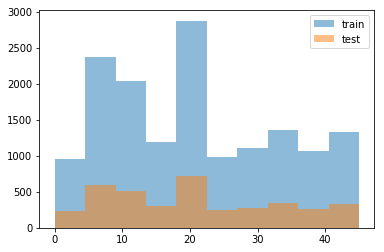

In [8]:
# Plot relative amount in each class to verify stratification
import random
import numpy
from matplotlib import pyplot
pyplot.hist(classes_train, alpha=0.5, label='train')
pyplot.hist(classes_test, alpha=0.5, label='test')
pyplot.legend(loc='upper right')
pyplot.show()

In [21]:
# First train an autoencoder to reduce the dimensionality of the input
# This might be the layer that re-capitulates the cancer gene list
# https://blog.keras.io/building-autoencoders-in-keras.html
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 1000  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(X_train.shape[1],))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(X_train.shape[1], activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(X_train, X_train,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 15300 samples, validate on 3826 samples
Epoch 1/5
  768/15300 [>.............................] - ETA: 278s - loss: -55.6116

In [16]:
from keras.layers import Dense, Dropout, Activation

model = Sequential()

# ~600 genes in cancer http://cancer.sanger.ac.uk/census/
model.add(Dense(800, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=2, shuffle='batch', batch_size=32)

Epoch 1/2
15300/15300 [==============================] - 369s - loss: 8.1892 - acc: 0.4916      

In [11]:
model.evaluate(X_test, y_test, batch_size=32)

3826/3826 [==============================] - 8s      

[8.8763270619896399, 0.44929430214323052]